In [1]:

ZIP_PATH = "/content/MBTA_Bus_Ridership_2016-2024.csv.zip"
import zipfile, pandas as pd, numpy as np, os, re
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)

def load_mbta_bus(zip_path: str) -> pd.DataFrame:
    assert os.path.exists(zip_path), f"Not found: {zip_path}"
    with zipfile.ZipFile(zip_path, 'r') as zf:
        csv_names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
        assert len(csv_names) >= 1, "No CSV in the zip!"
        with zf.open(csv_names[0]) as f:
            df = pd.read_csv(f, low_memory=False)
    return df

df = load_mbta_bus(ZIP_PATH)

for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()
for col in ["boardings", "alightings", "load_", "sample_size", "stop_sequence"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")


if "term_from_name" in df.columns and "year_from_name" in df.columns:
    df["term"] = df["term_from_name"]
    df["year"] = pd.to_numeric(df["year_from_name"], errors="coerce")
elif "season" in df.columns:
    term_year = df["season"].str.extract(r"(?P<term>[A-Za-z]+)\s+(?P<year>\d{4})")
    df["term"] = term_year["term"]
    df["year"] = pd.to_numeric(term_year["year"], errors="coerce")
else:
    df["term"], df["year"] = np.nan, np.nan


if "day_type_name" in df.columns:
    df["day_type_name"] = df["day_type_name"].str.lower()
else:
    df["day_type_name"] = np.nan

if "trip_start_time" in df.columns:
    def _to_hour(x):
        try: return int(str(x).split(":")[0])
        except: return np.nan
    df["hour"] = df["trip_start_time"].apply(_to_hour)
else:
    df["hour"] = np.nan

print("Rows:", len(df))
print("Columns:", len(df.columns))
if pd.notnull(df["year"]).any():
    print("Years:", int(df["year"].min()), "→", int(df["year"].max()))
print("Unique routes:", df["route_id"].nunique() if "route_id" in df.columns else "n/a")
print("Unique stops:", df["stop_id"].nunique() if "stop_id" in df.columns else "n/a")

df.head()


Rows: 7879638
Columns: 20
Years: 2016 → 2024
Unique routes: 173
Unique stops: 7863


,alightings,boardings,day_type_id,day_type_name,direction_id,load_,route_id,route_variant,sample_size,season,stop_id,stop_name,stop_sequence,trip_start_time,source_file,term_from_name,year_from_name,term,year,hour
0,0.3,0.4,day_type_01,weekday,0,7.8,1,1-0-0,13,Fall 2016,1,WASHINGTON ST OPP RUGGLES ST,2,04:37:00,MBTA_Bus_Ridership_by_Trip_Season_Route_Line_a...,Fall,2016,Fall,2016,4
1,0.0,0.1,day_type_01,weekday,0,9.4,1,1-0-0,13,Fall 2016,10003,ALBANY ST OPP RANDALL ST,5,04:37:00,MBTA_Bus_Ridership_by_Trip_Season_Route_Line_a...,Fall,2016,Fall,2016,4
2,0.4,0.0,day_type_01,weekday,0,10.4,1,1-0-0,13,Fall 2016,101,MASSACHUSETTS AVE @ SIDNEY ST,19,04:37:00,MBTA_Bus_Ridership_by_Trip_Season_Route_Line_a...,Fall,2016,Fall,2016,4
3,2.5,0.6,day_type_01,weekday,0,8.5,1,1-0-0,13,Fall 2016,102,MASSACHUSETTS AVE @ PROSPECT,20,04:37:00,MBTA_Bus_Ridership_by_Trip_Season_Route_Line_a...,Fall,2016,Fall,2016,4
4,0.2,0.1,day_type_01,weekday,0,8.4,1,1-0-0,13,Fall 2016,104,MASSACHUSETTS AVE @ BIGELOW S,21,04:37:00,MBTA_Bus_Ridership_by_Trip_Season_Route_Line_a...,Fall,2016,Fall,2016,4


**Total Ridership by Year (Weekday vs Weekend)**

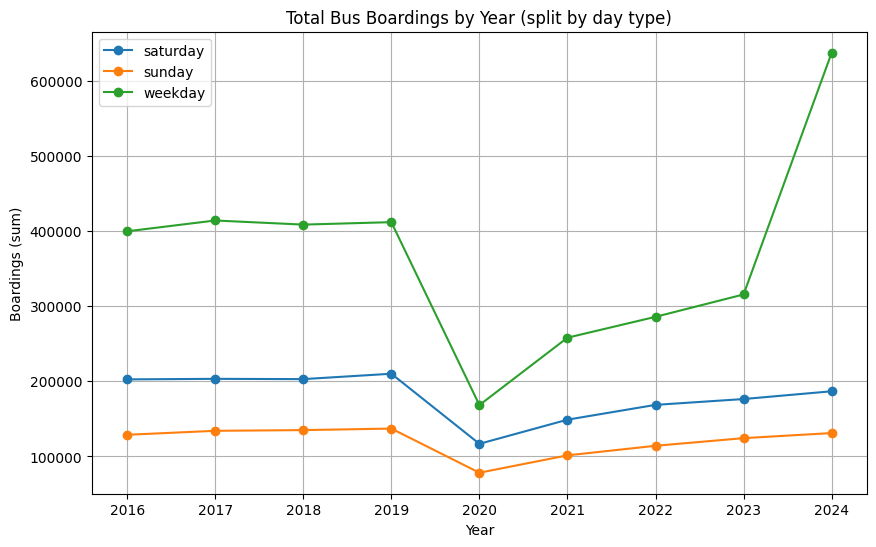

In [2]:
# Aggregate by year + day type (sum of boardings across stops)
mask = df["boardings"].notna() & df["year"].notna()
agg = df.loc[mask].groupby(["year","day_type_name"], as_index=False)["boardings"].sum()

# Pivot for line plot
piv = agg.pivot(index="year", columns="day_type_name", values="boardings").fillna(0.0)

plt.figure()
for col in piv.columns:
    plt.plot(piv.index, piv[col], marker='o', label=col)
plt.title("Total Bus Boardings by Year (split by day type)")
plt.xlabel("Year")
plt.ylabel("Boardings (sum)")
plt.legend()
plt.grid(True)
plt.show()


**Covid Drop & Recovery (Relative to 2019 Weekday)**

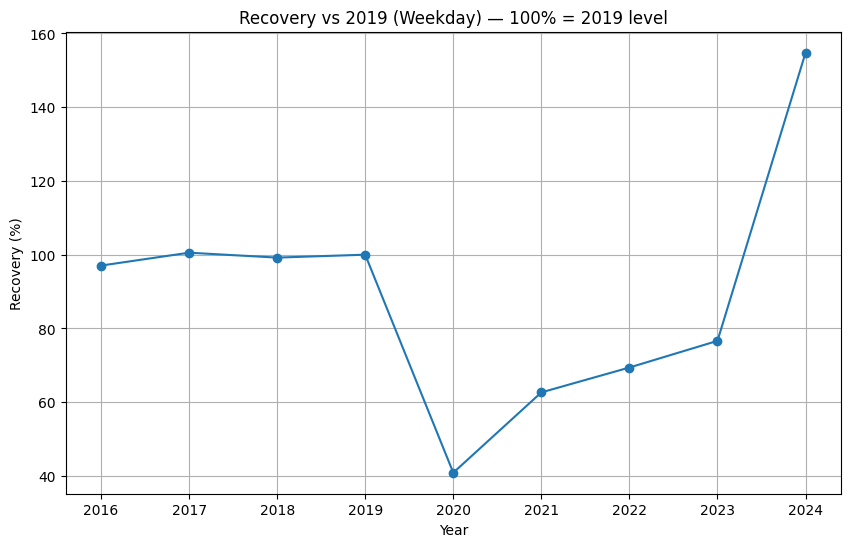

In [3]:
# Use weekday totals for a clean comparison
wk = agg[agg["day_type_name"].fillna("")=="weekday"].copy()
base_2019 = wk.loc[wk["year"]==2019, "boardings"].sum()

if base_2019 > 0:
    wk["recovery_vs_2019_%"] = 100 * wk["boardings"] / base_2019
    plt.figure()
    plt.plot(wk["year"], wk["recovery_vs_2019_%"], marker='o')
    plt.title("Recovery vs 2019 (Weekday) — 100% = 2019 level")
    plt.xlabel("Year"); plt.ylabel("Recovery (%)")
    plt.grid(True)
    plt.show()
else:
    print("No 2019 weekday baseline available.")


Top Routes (Latest Year, Weekday)

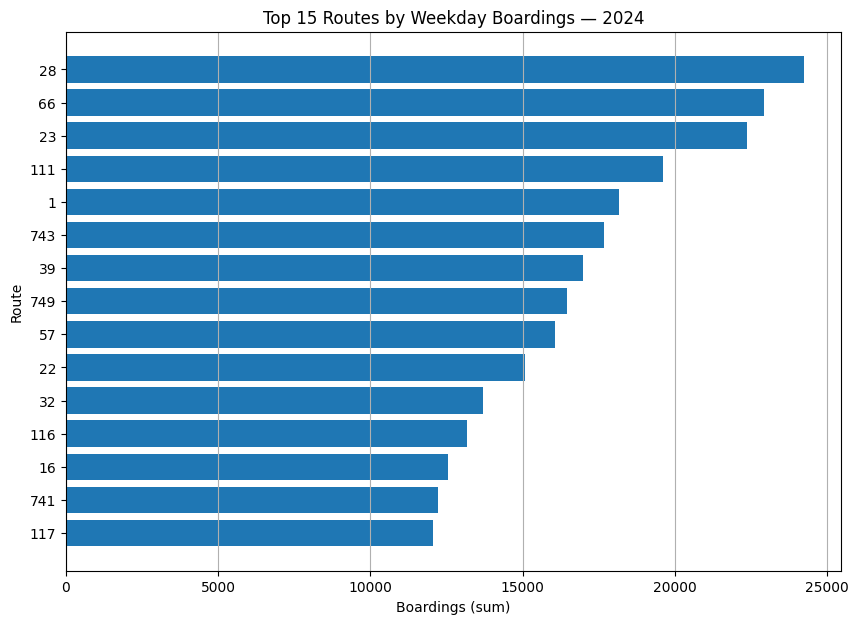

,route_id,boardings
51,28,24233.4
108,66,22908.9
43,23,22377.7
11,111,19601.1
0,1,18145.4
122,743,17666.5
66,39,16981.8
125,749,16466.4
101,57,16050.3
38,22,15081.1


In [4]:
latest_year = int(df["year"].dropna().max())
subset = df[(df["year"]==latest_year) & (df["boardings"].notna())]
if "day_type_name" in subset.columns:
    subset = subset[subset["day_type_name"].fillna("")=="weekday"]

by_route = subset.groupby("route_id", as_index=False)["boardings"].sum()
top_routes = by_route.sort_values("boardings", ascending=False).head(15)

plt.figure(figsize=(10,7))
plt.barh(top_routes["route_id"].astype(str), top_routes["boardings"])
plt.title(f"Top 15 Routes by Weekday Boardings — {latest_year}")
plt.xlabel("Boardings (sum)"); plt.ylabel("Route")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

top_routes.head(15)


**Top Routes (Latest Year, Weekday)**

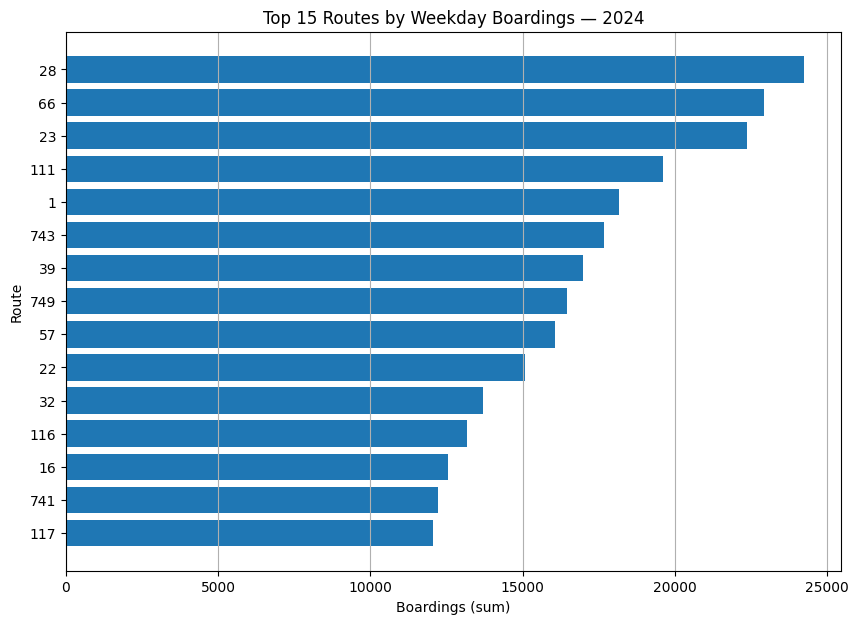

,route_id,boardings
51,28,24233.4
108,66,22908.9
43,23,22377.7
11,111,19601.1
0,1,18145.4
122,743,17666.5
66,39,16981.8
125,749,16466.4
101,57,16050.3
38,22,15081.1


In [5]:
latest_year = int(df["year"].dropna().max())
subset = df[(df["year"]==latest_year) & (df["boardings"].notna())]
if "day_type_name" in subset.columns:
    subset = subset[subset["day_type_name"].fillna("")=="weekday"]

by_route = subset.groupby("route_id", as_index=False)["boardings"].sum()
top_routes = by_route.sort_values("boardings", ascending=False).head(15)

plt.figure(figsize=(10,7))
plt.barh(top_routes["route_id"].astype(str), top_routes["boardings"])
plt.title(f"Top 15 Routes by Weekday Boardings — {latest_year}")
plt.xlabel("Boardings (sum)"); plt.ylabel("Route")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

top_routes.head(15)


**Stop Ranking for a Focus Route (Latest Year, Weekday)**

FOCUS_ROUTE = 28


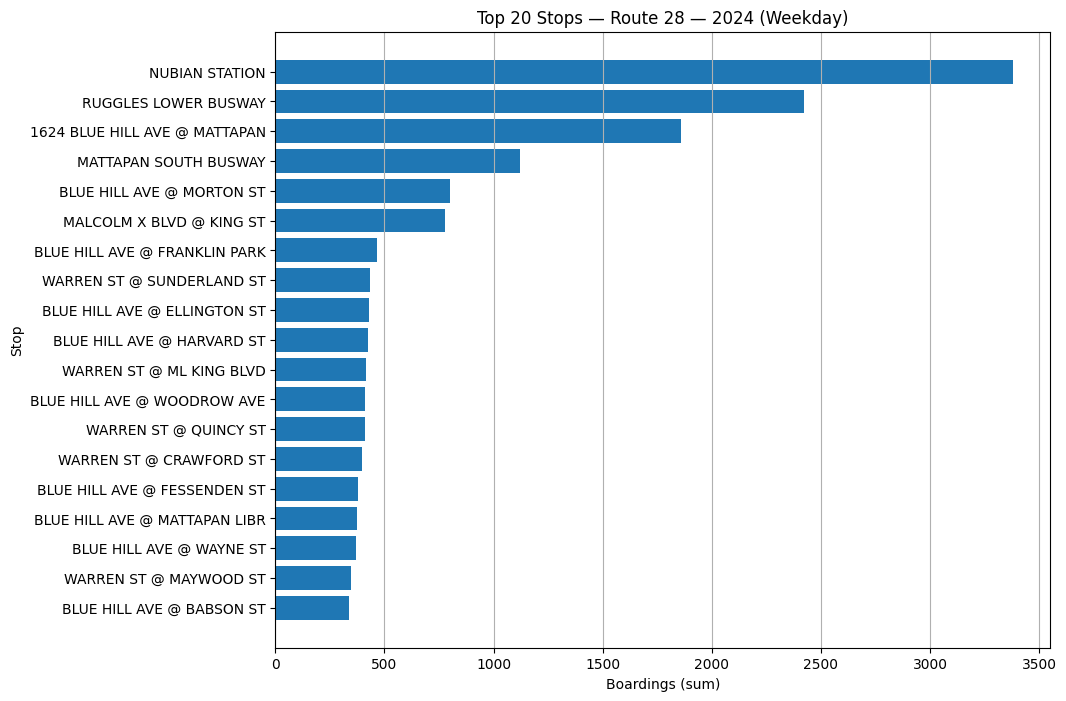

In [6]:

FOCUS_ROUTE = str(top_routes.iloc[0]["route_id"]) if len(top_routes) else None
print("FOCUS_ROUTE =", FOCUS_ROUTE)

if FOCUS_ROUTE is not None and "stop_name" in df.columns:
    rsub = subset[subset["route_id"].astype(str)==FOCUS_ROUTE]
    by_stop = rsub.groupby(["stop_id","stop_name"], as_index=False)["boardings"].sum()
    top_stops = by_stop.sort_values("boardings", ascending=False).head(20)

    plt.figure(figsize=(10,8))
    plt.barh(top_stops["stop_name"].astype(str), top_stops["boardings"])
    plt.title(f"Top 20 Stops — Route {FOCUS_ROUTE} — {latest_year} (Weekday)")
    plt.xlabel("Boardings (sum)"); plt.ylabel("Stop")
    plt.gca().invert_yaxis()
    plt.grid(axis='x')
    plt.show()

    top_stops.head(20)
else:
    print("No route/stops available for ranking.")


**Direction Comparison (Route-level)**

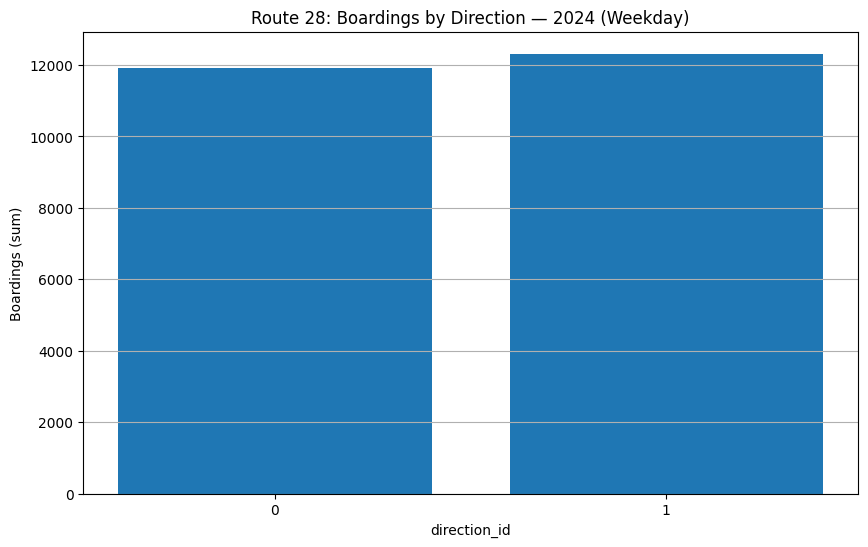

In [7]:
if FOCUS_ROUTE is not None and "direction_id" in df.columns:
    dir_agg = subset[subset["route_id"].astype(str)==FOCUS_ROUTE] \
        .groupby("direction_id", as_index=False)["boardings"].sum() \
        .sort_values("direction_id")

    plt.figure()
    plt.bar(dir_agg["direction_id"].astype(str), dir_agg["boardings"])
    plt.title(f"Route {FOCUS_ROUTE}: Boardings by Direction — {latest_year} (Weekday)")
    plt.xlabel("direction_id"); plt.ylabel("Boardings (sum)")
    plt.grid(axis='y')
    plt.show()

    dir_agg
else:
    print("Direction analysis not available.")


Hour-of-Day Profile (Route-level)

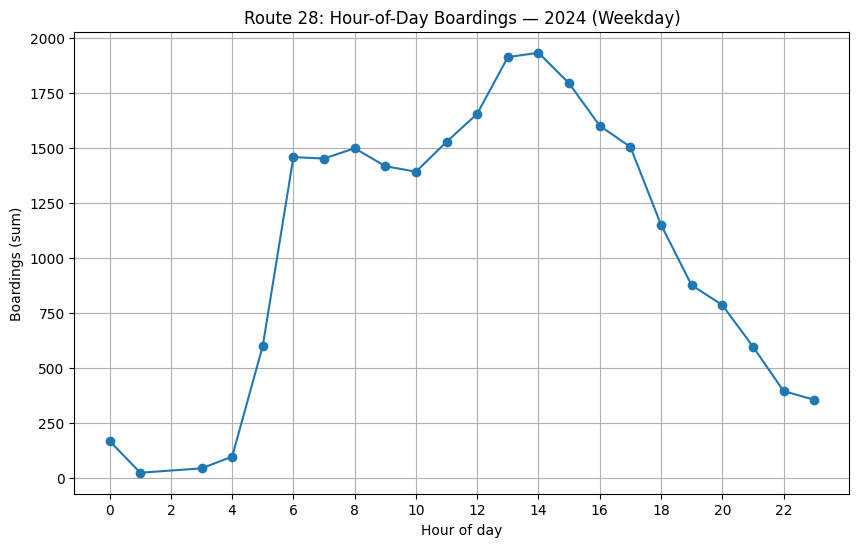

In [8]:
if FOCUS_ROUTE is not None and "hour" in df.columns:
    hsub = subset[(subset["route_id"].astype(str)==FOCUS_ROUTE) & (subset["hour"].notna())]
    by_hour = hsub.groupby("hour", as_index=False)["boardings"].sum().sort_values("hour")

    plt.figure()
    plt.plot(by_hour["hour"], by_hour["boardings"], marker='o')
    plt.title(f"Route {FOCUS_ROUTE}: Hour-of-Day Boardings — {latest_year} (Weekday)")
    plt.xlabel("Hour of day"); plt.ylabel("Boardings (sum)")
    plt.grid(True)
    plt.xticks(range(0,24,2))
    plt.show()

    by_hour
else:
    print("No hour-of-day information available.")


Load Factor Distribution (All Routes, Latest Year)

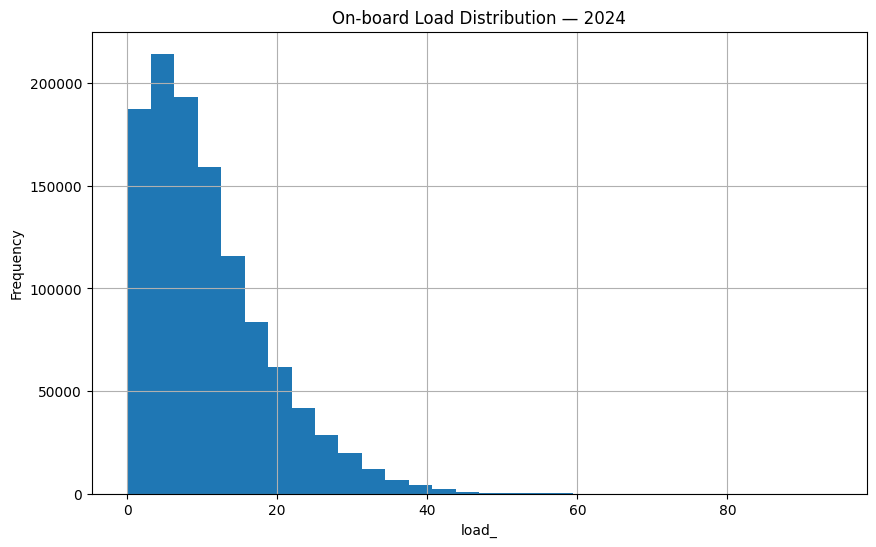

In [9]:
if "load_" in df.columns and df["load_"].notna().any():
    lsub = df[(df["year"]==latest_year) & (df["load_"].notna())]
    plt.figure()
    plt.hist(lsub["load_"].values, bins=30)
    plt.title(f"On-board Load Distribution — {latest_year}")
    plt.xlabel("load_"); plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("No load_ field available for histogram.")


Multi-Year Route Trend (Top N routes)

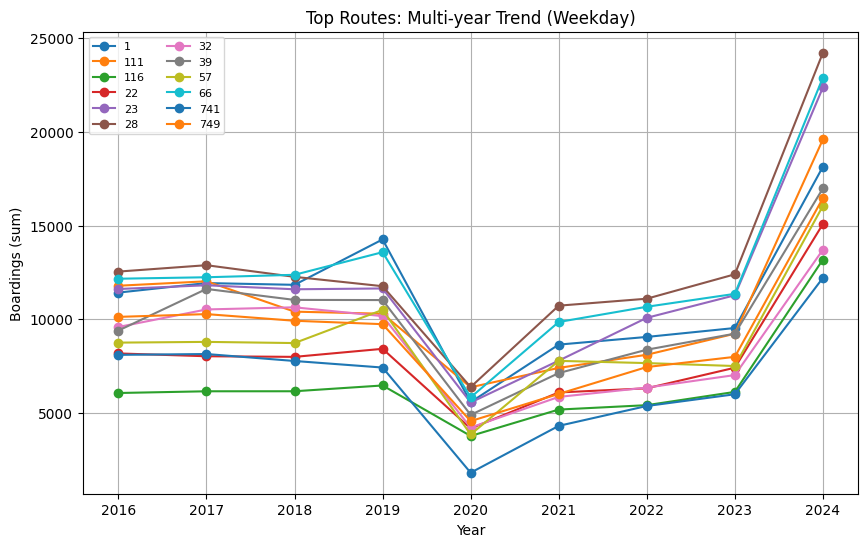

,year,route_id,boardings
0,2016,1,11416.3
1,2016,111,11782.9
2,2016,116,6051.3
3,2016,22,8165.7
4,2016,23,11607.7


In [10]:
# Identify top N routes by total boardings across all years (weekday)
wk_all = df[df["boardings"].notna()]
if "day_type_name" in wk_all.columns:
    wk_all = wk_all[wk_all["day_type_name"].fillna("")=="weekday"]

topN = wk_all.groupby("route_id", as_index=False)["boardings"].sum() \
             .sort_values("boardings", ascending=False) \
             .head(12)["route_id"].astype(str).tolist()

trend = wk_all[wk_all["route_id"].astype(str).isin(topN)] \
    .groupby(["year","route_id"], as_index=False)["boardings"].sum()

plt.figure()
for rid in sorted(set(trend["route_id"].astype(str))):
    s = trend[trend["route_id"].astype(str)==rid].sort_values("year")
    plt.plot(s["year"], s["boardings"], marker='o', label=str(rid))
plt.title("Top Routes: Multi-year Trend (Weekday)")
plt.xlabel("Year"); plt.ylabel("Boardings (sum)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

trend.head()


Route Growth Leaders (2019 → Latest, Weekday)

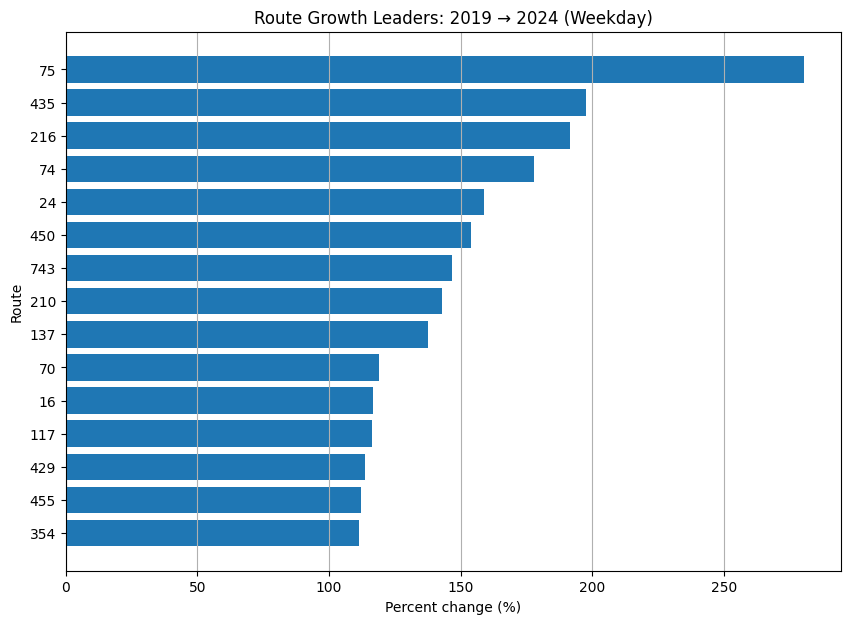

,route_id,base,cur,pct_change_%
124,75,481.5,1831.5,280.373832
77,435,627.2,1867.5,197.751913
36,216,1071.7,3125.0,191.592796
117,74,730.2,2027.7,177.691044
46,24,1661.9,4299.6,158.715928
84,450,1508.0,3831.5,154.078249
120,743,7163.2,17666.5,146.628602
33,210,646.7,1571.9,143.064790
22,137,942.3,2240.2,137.737451
111,70,4675.0,10229.9,118.821390


In [11]:
yr0, yr1 = 2019, latest_year
base = wk_all[wk_all["year"]==yr0].groupby("route_id", as_index=False)["boardings"].sum().rename(columns={"boardings":"base"})
cur  = wk_all[wk_all["year"]==yr1].groupby("route_id", as_index=False)["boardings"].sum().rename(columns={"boardings":"cur"})
gr = pd.merge(base, cur, on="route_id", how="inner")
gr = gr[gr["base"] > 0]
gr["pct_change_%"] = 100 * (gr["cur"] - gr["base"]) / gr["base"]
leaders = gr.sort_values("pct_change_%", ascending=False).head(15)

plt.figure(figsize=(10,7))
plt.barh(leaders["route_id"].astype(str), leaders["pct_change_%"])
plt.title(f"Route Growth Leaders: {yr0} → {yr1} (Weekday)")
plt.xlabel("Percent change (%)"); plt.ylabel("Route")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

leaders.head(15)


Route-Year Heatmap (Boardings)

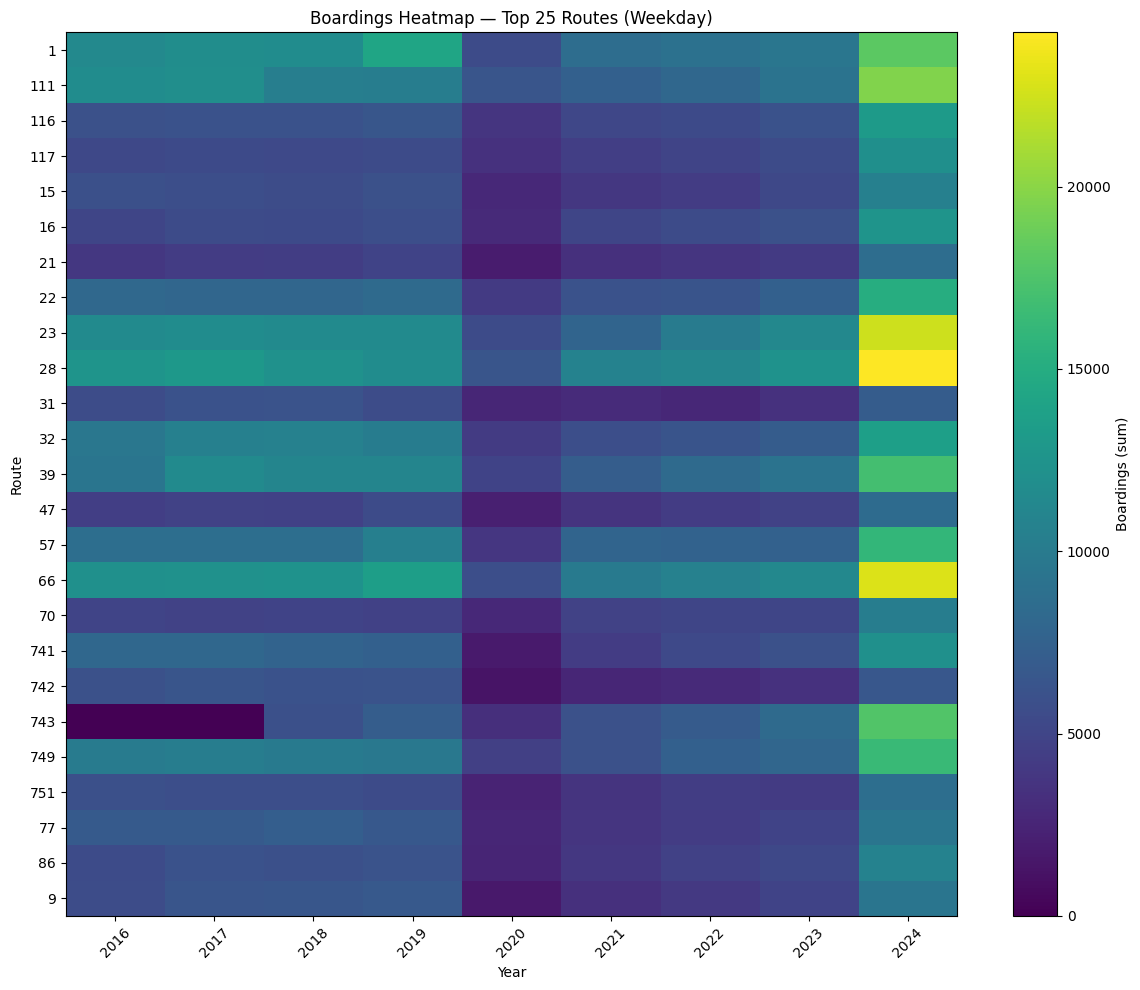

In [12]:
# Simple heatmap using imshow (no seaborn, no explicit cmap)
mat = wk_all.groupby(["route_id","year"], as_index=False)["boardings"].sum()
# Keep top 25 routes by total
top25 = mat.groupby("route_id", as_index=False)["boardings"].sum().sort_values("boardings", ascending=False).head(25)["route_id"]
mat = mat[mat["route_id"].isin(top25)]

years = sorted(mat["year"].dropna().unique().tolist())
routes = [str(x) for x in sorted(set(mat["route_id"]))]

M = np.zeros((len(routes), len(years)))
for i, r in enumerate(routes):
    for j, y in enumerate(years):
        v = mat[(mat["route_id"]==r) & (mat["year"]==y)]["boardings"].sum()
        M[i, j] = v

plt.figure(figsize=(12,10))
plt.imshow(M, aspect='auto')  # default colormap
plt.title("Boardings Heatmap — Top 25 Routes (Weekday)")
plt.xlabel("Year"); plt.ylabel("Route")
plt.xticks(range(len(years)), years, rotation=45)
plt.yticks(range(len(routes)), routes)
plt.colorbar(label="Boardings (sum)")
plt.tight_layout()
plt.show()
